##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Pose Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect pose landmarks from images.

## Preparation

Let's start with installing MediaPipe.


In [1]:
!pip install -q mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 11.1 MB/s eta 0:00:00


Then download an off-the-shelf model bundle. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker#models) for more information about this model bundle.

In [5]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

## Visualization utilities

In [2]:
#@markdown To better demonstrate the Pose Landmarker API, we have created a set of visualization tools that will be used in this colab. These will draw the landmarks on a detect person, as well as the expected connections between those markers.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

## Download test image

To demonstrate the Pose Landmarker API, you can download a sample image using the follow code. The image is from [Pixabay](https://pixabay.com/photos/girl-woman-fitness-beautiful-smile-4051811/).

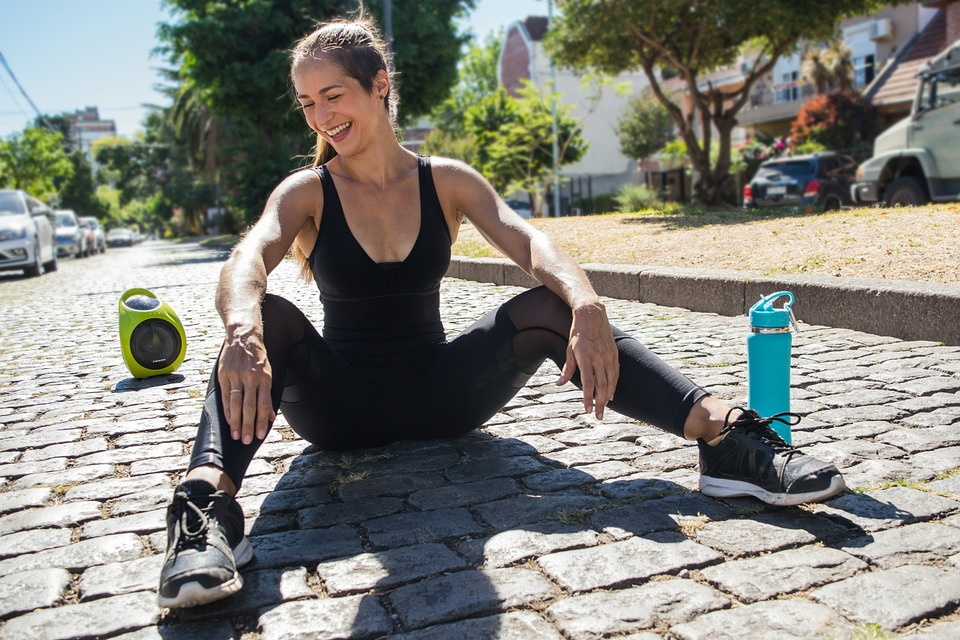

In [8]:
!wget -q -O image.jpg https://cdn.pixabay.com/photo/2019/03/12/20/39/girl-4051811_960_720.jpg

import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("image.jpg")
cv2_imshow(img)

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [ ]:
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

## Running inference and visualizing the results

The final step is to run pose landmark detection on your selected image. This involves creating your PoseLandmarker object, loading your image, running detection, and finally, the optional step of displaying the image with visualizations.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker/python) to learn more about configuration options that this solution supports.


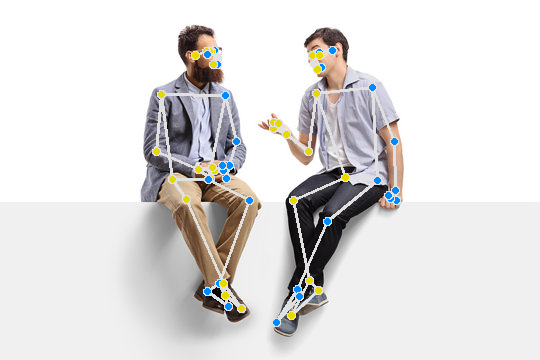

In [9]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True,num_poses=2)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("2p.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

Visualize the pose segmentation mask.

In [ ]:
segmentation_mask = detection_result.segmentation_masks[0].numpy_view()
visualized_mask = np.repeat(segmentation_mask[:, :, np.newaxis], 3, axis=2) * 255
cv2_imshow(visualized_mask)

In [10]:
# Import necessary modules
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.framework.formats import landmark_pb2
import numpy as np

# Function to draw landmarks on an image
def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected poses to visualize.
    for pose_landmarks in pose_landmarks_list:
        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z)
            for landmark in pose_landmarks
        ])
        mp.solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            mp.solutions.pose.POSE_CONNECTIONS,
            mp.solutions.drawing_styles.get_default_pose_landmarks_style()
        )
    return annotated_image

# Initialize the PoseLandmarker
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=False,  # Set to True if you also want segmentation masks # Adjust for detecting multiple people
)
detector = vision.PoseLandmarker.create_from_options(options)

# Open the video file
video_path = "input_video.mp4"  # Replace with your video file path
cap = cv2.VideoCapture(video_path)

# Define the codec and create a VideoWriter object to save the annotated video
output_path = "output_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Process the video frame by frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to an MP Image
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)

    # Detect poses in the current frame
    detection_result = detector.detect(mp_image)

    # Draw landmarks on the frame
    annotated_frame = draw_landmarks_on_image(frame, detection_result)

    # Write the annotated frame to the output video
    out.write(annotated_frame)



# Release resources
cap.release()
out.release()


In [11]:
detection_result.pose_landmarks

[]